In [1]:
import pickle
from pathlib import Path
from typing import Literal
from math import ceil
from textwrap import wrap

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from ipyleaflet import Map, Marker
from ipywidgets import Layout, HTML

import dataretrieval.nwis as nwis

In [2]:
def get_nwis_data(sites: list[str], start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
    """
    Query NWIS service to get site records
    """

    # Parse dates to strings for NWIS
    str_start = start.strftime(r"%Y-%m-%d")
    str_end = end.strftime(r"%Y-%m-%d")

    # get site information
    site_info, md = nwis.get_info(sites=sites)

    # get daily values (dv)
    df_daily = nwis.get_record(service="dv", sites=sites, start=str_start, end=str_end)

    # get instantaneous values (iv)
    df_iv = nwis.get_record(service="iv", sites=sites, start=str_start, end=str_end)

    # get parameter descriptions
    parameter_codes = list(
        set([col.partition("_")[0] for col in df_daily.columns if col[0].isdigit()])
    )

    df_parameter_descriptions = nwis.get_record(parameterCd=parameter_codes, service="pmcodes")

    return {
        "df_daily": df_daily,
        "df_instantaneous": df_iv,
        "site_info": site_info,
        "parameter_codes": df_parameter_descriptions,
    }


# target folder
target_path = Path("usgs")
target_path.mkdir(exist_ok=True)

In [3]:
which: Literal["Near Markham", "Cook County"] = "Cook County"

if which == "Near Markham":
    sites = [
        "413548087395901",  # RAIN GAGE AT CALUMET UNION DR CANAL NR MARKHAM, IL
        "413516087442101",  # RAIN GAGE AT OAK FOREST, IL
        "413510087380201",  # RAIN GAGE AT HARVEY, IL
        "414028087383501",  # RAIN GAGE AT WEST PULLMAN AT CHICAGO, IL
        "414030087450001",  # RAIN GAGE AT ALSIP, IL
        "413104087440001",  # RAIN GAGE AT MATTESON, IL
    ]

elif which == "Cook County":
    sites = pd.read_parquet("usgs/gauges_in_cook_county.parquet")["site_no"].astype(str).to_list()

start = pd.Timestamp("2021-01-01 00:00:00")
end = pd.Timestamp("2022-01-01 00:00:00")

In [4]:
if (data_path := target_path / f"usgs_{which}.pkl").exists():
    with open(data_path, "rb") as f:
        data = pickle.load(f)

else:
    data = get_nwis_data(sites=sites, start=start, end=end)
    with open(data_path, "wb") as f:
        pickle.dump(data, f)

daily, df, site_info, pcodes = data.values()

In [5]:
daily.head()

00045_Sum 00045_Sum_cd  00060_Mean  \
site_no  datetime                                                        
05530990 2021-01-01 00:00:00+00:00       0.23            A        17.1   
         2021-01-02 00:00:00+00:00       0.20            A        24.5   
         2021-01-03 00:00:00+00:00       0.05            A        19.9   
         2021-01-04 00:00:00+00:00       0.00            A        16.2   
         2021-01-05 00:00:00+00:00       0.01            A        13.8   

                                   00060_Mean_cd  00065_Mean 00065_Mean_cd  \
site_no  datetime                                                            
05530990 2021-01-01 00:00:00+00:00             A        2.59             A   
         2021-01-02 00:00:00+00:00             A        2.75             A   
         2021-01-03 00:00:00+00:00             A        2.66             A   
         2021-01-04 00:00:00+00:00             A        2.58             A   
         2021-01-05 00:00:00+00:00             A        2.53             A   

                                    00020_Maximum 00020_Maximum_cd  \
site_no  datetime                                                    
05530990 2021-01-01 00:00:00+00:00            NaN              NaN   
         2021-01-02 00:00:00+00:00            NaN              NaN   
         2021-01-03 00:00:00+00:00            NaN              NaN   
         2021-01-04 00:00:00+00:00            NaN              NaN   
         2021-01-05 00:00:00+00:00            NaN              NaN   

                                    00020_Minimum 00020_Minimum_cd  \
site_no  datetime                                                    
05530990 2021-01-01 00:00:00+00:00            NaN              NaN   
         2021-01-02 00:00:00+00:00            NaN              NaN   
         2021-01-03 00:00:00+00:00            NaN              NaN   
         2021-01-04 00:00:00+00:00            NaN              NaN   
         2021-01-05 00:00:00+00:00            NaN              NaN   

                                    00020_Mean 00020_Mean_cd  
site_no  datetime                                             
05530990 2021-01-01 00:00:00+00:00         NaN           NaN  
         2021-01-02 00:00:00+00:00         NaN           NaN  
         2021-01-03 00:00:00+00:00         NaN           NaN  
         2021-01-04 00:00:00+00:00         NaN           NaN  
         2021-01-05 00:00:00+00:00         NaN           NaN

In [6]:
# Use only sites with data
assert len(df.index.get_level_values("site_no").unique()) == len(
    daily.index.get_level_values("site_no").unique()
)

sites = daily.index.get_level_values("site_no").unique().to_list()

/tmp/ipykernel_212518/3460177495.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


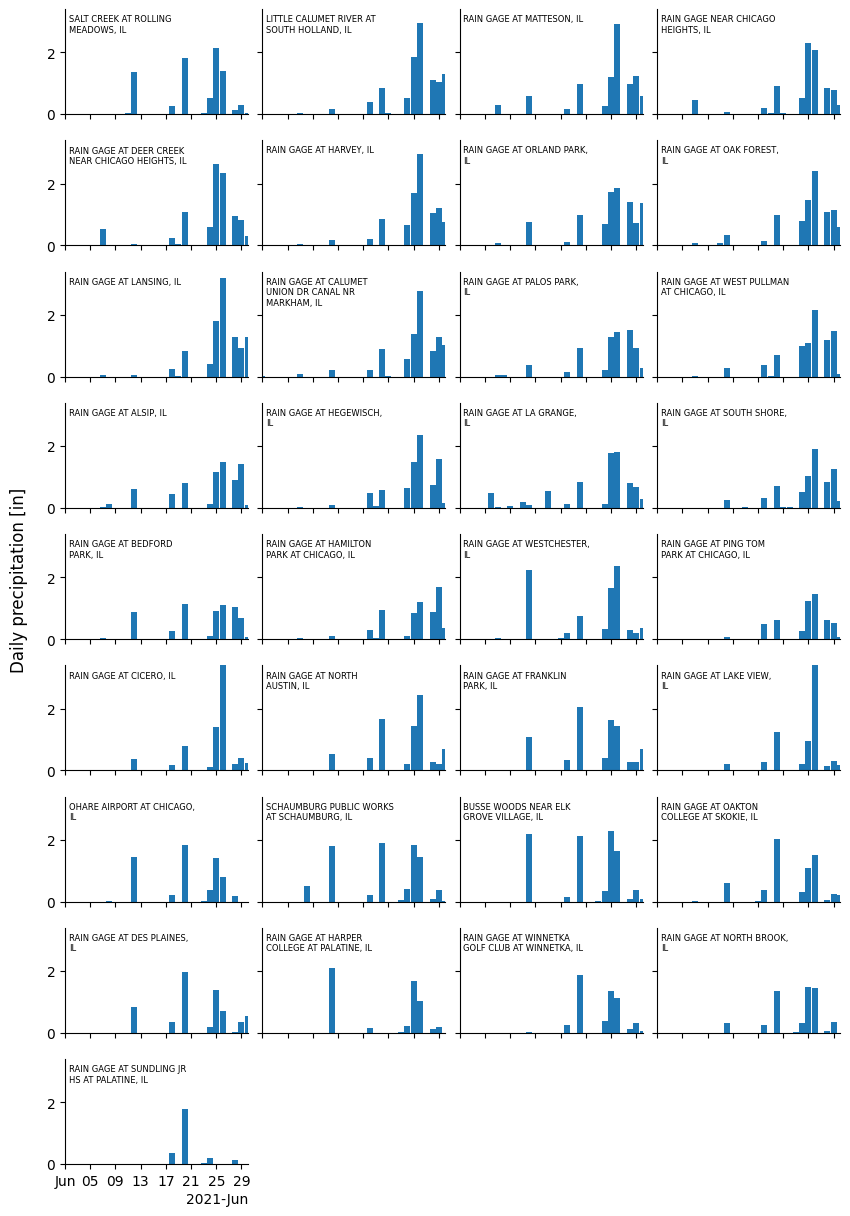

In [7]:
fig, axs = plt.subplots(
    ceil(len(sites) / 4),
    4,
    sharex=True,
    sharey=True,
    figsize=(10, 15),
    gridspec_kw={"hspace": 0.25, "wspace": 0.08},
)

for ax, site in zip(axs.flatten(), sites):
    subdf = daily.xs(site)["00045_Sum"]
    ax.bar(subdf.index, subdf, width=pd.Timedelta("0.95d"))
    title = site_info.set_index("site_no").loc[site]["station_nm"]
    wrapped_title = "\n".join(wrap(title, width=25))
    ax.text(0.02, 0.95, wrapped_title, fontsize=6, transform=ax.transAxes, ha="left", va="top")
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.set_xlim(pd.Timestamp("2021-06-01"), pd.Timestamp("2021-06-30"))

ax.set_ylim(0, 3.4)
fig.supylabel("Daily precipitation [in]", x=0.07)

for ax in axs.flatten()[len(sites) :]:
    ax.remove()

fig.tight_layout()
plt.show()

In [8]:
site_info

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,05530990,"SALT CREEK AT ROLLING MEADOWS, IL",ST,420337.41,880059.97,42.060392,-88.016658,N,5,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-88.01666 42.06039)
1,USGS,05536290,"LITTLE CALUMET RIVER AT SOUTH HOLLAND, IL",ST,413625.30,873551.30,41.607028,-87.597583,X,F,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-87.59758 41.60703)
2,USGS,413104087440001,"RAIN GAGE AT MATTESON, IL",AT,413104.00,874400.00,41.517778,-87.733333,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS0,POINT (-87.73333 41.51778)
3,USGS,413113087342201,"RAIN GAGE NEAR CHICAGO HEIGHTS, IL",AT,413115.00,873525.00,41.520868,-87.590321,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,00100,POINT (-87.59032 41.52087)
4,USGS,413115087352501,"RAIN GAGE AT DEER CREEK NEAR CHICAGO HEIGHTS, IL",AT,413115.00,873525.00,41.520833,-87.590278,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.59028 41.52083)
5,USGS,413510087380201,"RAIN GAGE AT HARVEY, IL",AT,413510.00,873802.00,41.586111,-87.633889,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.63389 41.58611)
6,USGS,413514087523501,"RAIN GAGE AT ORLAND PARK, IL",AT,413514.00,875235.00,41.587222,-87.876389,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS000,POINT (-87.87639 41.58722)
7,USGS,413516087442101,"RAIN GAGE AT OAK FOREST, IL",AT,413516.00,874421.00,41.587778,-87.739167,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.73917 41.58778)
8,USGS,413518087324901,"RAIN GAGE AT LANSING, IL",AT,413518.00,873249.00,41.588333,-87.546944,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.54694 41.58833)
9,USGS,413548087395901,RAIN GAGE AT CALUMET UNION DR CANAL NR MARKHAM...,AT,413548.00,873959.00,41.596667,-87.666389,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001UM,POINT (-87.66639 41.59667)


In [9]:
pcodes

,parameter_cd,group,parm_nm,epa_equivalence,result_statistical_basis,result_time_basis,result_weight_basis,result_particle_size_basis,result_sample_fraction,result_temperature_basis,CASRN,SRSName,parm_unit
0,00065,Physical,"Gage height, feet",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,"Height, gage",ft
0,00020,Physical,"Temperature, air, degrees Celsius",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,"Temperature, air, deg C",deg C
0,00060,Physical,"Discharge, cubic feet per second",Not checked,Mean,1 Day,NaN,NaN,NaN,NaN,,"Stream flow, mean. daily",ft3/s
0,00045,Physical,"Precipitation, total, inches",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,Precipitation,in


In [11]:
center = site_info["dec_lat_va"].mean(), site_info["dec_long_va"].mean()
m = Map(center=center, zoom=9, layout=Layout(height="500px"))

for i, site in site_info.iterrows():
    coord = site["dec_lat_va"], site["dec_long_va"]
    name = site["station_nm"]
    marker = Marker(location=coord, draggable=False, title=name)
    marker.popup = HTML(f"<small>{name}</small>")
    m.add_layer(marker)

display(m)

Map(center=[np.float64(41.80941200878788), np.float64(-87.7735030530303)], controls=(ZoomControl(options=['pos…